In [ ]:
!nvidia-smi

In [ ]:
!pip install -q gdown inference-gpu
!pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

In [ ]:
!pip install -q git+https://github.com/roboflow/sports.git

In [ ]:
!pip uninstall -y supervision && pip install -q supervision>=0.23.0

In [ ]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

In [ ]:
from inference import get_model

ROBOFLOW_API_KEY = 'tCy476DHnSoq6mwGtVpp'
PLAYER_DETECTION_MODEL_ID = 'football-players-detection-3zvbc/12'
PLAYER_DETECTION_MODEL = get_model(PLAYER_DETECTION_MODEL_ID, ROBOFLOW_API_KEY)


In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "content/08fd33_4.mp4"

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "content/08fd33_4.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "content/08fd33_4.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

split players into teams with siglip, umap and kmeans

In [ ]:
#crop up players by their bounding boxes
from tqdm import tqdm

SOURCE_VIDEO_PATH = "content/08fd33_4.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops
 
#Note: Here's a sample (100 elements) of the crops we've gathered.   
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

In [ ]:
#Note: Next, we'll run SigLIP to calculate embeddings for each of the crops.
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [ ]:
#This code performs batch processing of image crops to extract embeddings (numerical representations) using a deep learning model
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

In [ ]:
#Note: Using UMAP, we project our embeddings from (N, 768) to (N, 3) and then perform a two-cluster division using KMeans.
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [ ]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "content/08fd33_4.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cpu")
team_classifier.fit(crops)

In [29]:
#Time to assign goalkeepers to teams. We'll use a simple heuristic: 
# calculate the average position (centroid) of the players belonging to both teams and then assign the goalkeeper to the team whose average position is closer.
import numpy as np
import supervision as sv

GK_TEAM_1_ID = 11
GK_TEAM_2_ID = 22

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        if dist_0 < dist_1:
            goalkeepers_team_id.append(GK_TEAM_1_ID)
        else:
            goalkeepers_team_id.append(GK_TEAM_2_ID)

    return np.array(goalkeepers_team_id)


Embedding extraction: 1it [00:04,  4.91s/it]


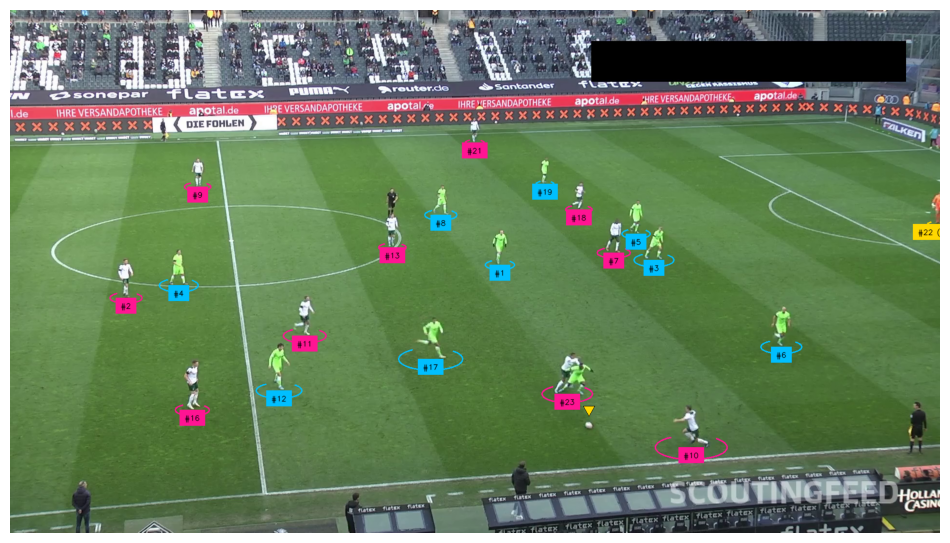

In [33]:
#team assignment and goalkeepers team assignment workking together
import supervision as sv

SOURCE_VIDEO_PATH = "content/08fd33_4.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
#referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections]) #referees_detections

'''
labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]
'''

labels = [
    f"#{tracker_id} (GK)" if class_id in [GK_TEAM_1_ID, GK_TEAM_2_ID] else f"#{tracker_id}"
    for tracker_id, class_id in zip(all_detections.tracker_id, all_detections.class_id)
]

#all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()

annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)

annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

KEYPOINTS SECTION

In [ ]:
from inference import get_model

ROBOFLOW_API_KEY = 'tCy476DHnSoq6mwGtVpp'
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/15"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "content/08fd33_4.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

In [ ]:
#filter low confidence keypoints
import supervision as sv
import numpy as np

SOURCE_VIDEO_PATH = "content/08fd33_4.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

project pitch lines on frame

In [ ]:
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

In [ ]:
import numpy as np
import supervision as sv
from sports.common.view import ViewTransformer

SOURCE_VIDEO_PATH = "content/08fd33_4.mp4"

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

project ball, players and referies on pitch

In [34]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "content/08fd33_4.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cpu")
team_classifier.fit(crops)

collecting crops: 25it [03:24,  8.18s/it]
Embedding extraction: 19it [02:17,  7.22s/it]


In [38]:
frames = []

for frame_index, frame in enumerate(sv.get_video_frames_generator(SOURCE_VIDEO_PATH)):
    if frame_index % 300 == 0:  # Save only every 10th frame
        frames.append(frame)

print(f"Total frames collected: {len(frames)}")

Total frames collected: 3


Frame 0


Processing...:   0%|          | 0/3 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.98s/it]


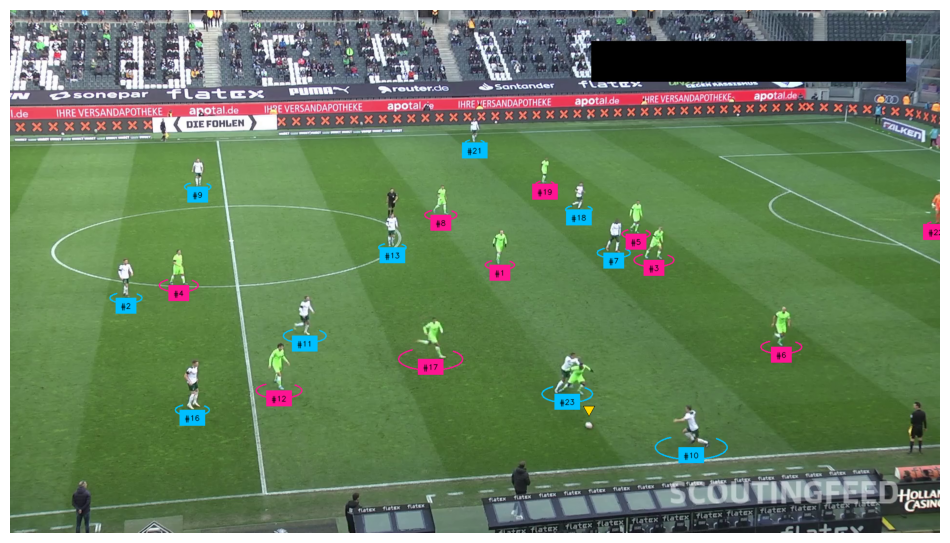

Frame 1


Processing...:  33%|███▎      | 1/3 [00:16<00:33, 16.55s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.14s/it]


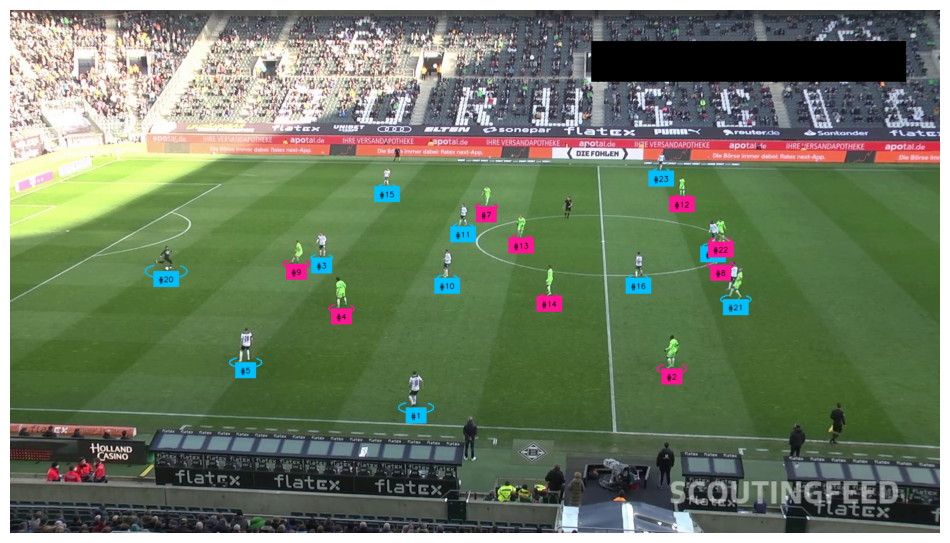

Frame 2


Processing...:  67%|██████▋   | 2/3 [00:33<00:16, 16.70s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.95s/it]


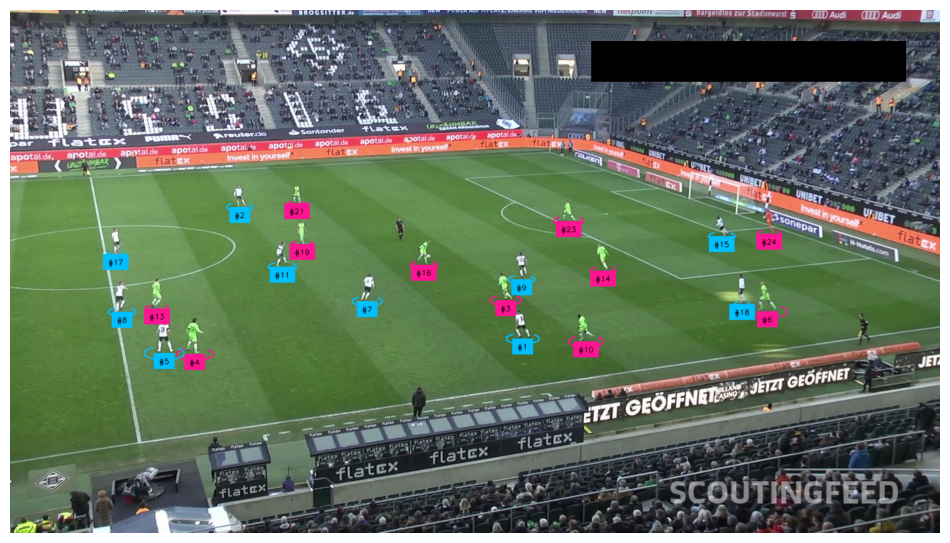

Processing...: 100%|██████████| 3/3 [00:51<00:00, 17.17s/it]


In [44]:
import supervision as sv
import cv2
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch
)

field_View_frames = []
virtField_View_frames = []

ball_positions = []
gk_positions = []

gk_team_1_positions = []
gk_team_2_positions = []

tracker = sv.ByteTrack()
frame_counter = 0

for frame_index, frame in enumerate(tqdm(frames, desc="Processing...")):
    tqdm.write(f"Frame {frame_index}")
        
    # ball, goalkeeper, player, referee detection
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
    
    if len(ball_detections.xyxy) > 0:
        x_min, y_min, x_max, y_max = ball_detections.xyxy[0]  # Assuming one ball per frame
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        ball_positions.append((frame_index, x_center, y_center))
    else:
        ball_positions.append((frame_index, None, None))  # No ball detected in this frame

    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections = tracker.update_with_detections(detections=all_detections)

    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    
    # Assign teams to goalkeepers
    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

    # Track goalkeeper positions
    for gk_xyxy, gk_class_id in zip(goalkeepers_detections.xyxy, goalkeepers_detections.class_id):
        x_min, y_min, x_max, y_max = gk_xyxy
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2

        if gk_class_id == GK_TEAM_1_ID:
            gk_team_1_positions.append((frame_index, x_center, y_center))
        elif gk_class_id == GK_TEAM_2_ID:
            gk_team_2_positions.append((frame_index, x_center, y_center))
    
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]
    
    #referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

    # team assignment
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(players_crops)

    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
        players_detections, goalkeepers_detections)

    #referees_detections.class_id -= 1

    all_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections]) #referees_detections

    # frame visualization
    labels = [
        f"#{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
    ]

    all_detections.class_id = all_detections.class_id.astype(int)

    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections,
        labels=labels)
    annotated_frame = triangle_annotator.annotate(
        scene=annotated_frame,
        detections=ball_detections)

    field_View_frames.append(annotated_frame)
    sv.plot_image(annotated_frame)

    players_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections
    ])

    # detect pitch key points
    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)

    # project ball, players and referies on pitch
    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_players_xy = transformer.transform_points(points=players_xy)

    #referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    #pitch_referees_xy = transformer.transform_points(points=referees_xy)

    # visualize video game-style radar view
    '''
    annotated_frame = draw_pitch(CONFIG)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 0],
        face_color=sv.Color.from_hex('00BFFF'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 1],
        face_color=sv.Color.from_hex('FF1493'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_referees_xy,
        face_color=sv.Color.from_hex('FFD700'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame)
        
    #virtField_View_frames.append(annotated_frame)
    '''
    
    tracker.reset()

In [50]:
# Loop through ball positions and goalkeeper positions
for (frame_index, ball_x, ball_y) in ball_positions:
    # Get the goalkeeper positions for the current frame
    gk_team_1_position = next((pos for pos in gk_team_1_positions if pos[0] == frame_index), None)
    gk_team_2_position = next((pos for pos in gk_team_2_positions if pos[0] == frame_index), None)

    # Print ball position
    print(f"Frame {frame_index}: Ball ({ball_x}, {ball_y})")

    # Print goalkeeper positions
    if gk_team_1_position:
        print(f"Frame {frame_index}: GK Team 1 Position: ({gk_team_1_position[1]}, {gk_team_1_position[2]})")
    else:
        print(f"Frame {frame_index}: GK Team 1 Position: None")

    if gk_team_2_position:
        print(f"Frame {frame_index}: GK Team 2 Position: ({gk_team_2_position[1]}, {gk_team_2_position[2]})")
    else:
        print(f"Frame {frame_index}: GK Team 2 Position: None")

Frame 0: Ball (1195.5, 857.5)
Frame 0: GK Team 1 Position: None
Frame 0: GK Team 2 Position: (1911.5, 409.5)
Frame 1: Ball (None, None)
Frame 1: GK Team 1 Position: None
Frame 1: GK Team 2 Position: None
Frame 2: Ball (None, None)
Frame 2: GK Team 1 Position: None
Frame 2: GK Team 2 Position: (1153.5, 415.0)


In [47]:
#save array as csv
import numpy as np

np.savetxt("../data/raw/ball_positions.csv", ball_positions, delimiter=",", header="Frame, X, Y", comments='',fmt='%s')
np.savetxt("../data/raw/gk_positions.csv", gk_positions, delimiter=",", header="Frame, X, Y", comments='',fmt='%s')
